# 📊 Access Public Economic and Financial Data using Python

This exercise demonstrates how to retrieve real-time and historical financial data using public APIs. You'll learn how to:

- Make HTTP requests to economic and financial data APIs
- Clean and analyze JSON responses with pandas
- Visualize results with `plotly`

We'll use the following data sources:
- [U.S. Treasury Fiscal Data API](https://fiscaldata.treasury.gov/) for exchange rates and interest rates
- [FRED API (Federal Reserve Economic Data)](https://fred.stlouisfed.org/docs/api/fred/) for weekly gas prices

## What is an API?

An API (Application Programming Interface) is like a messenger that allows two computer programs to talk to each other. Imagine you're the client (like a web browser or app), and you want some data - like gas prices - from another computer (the server). You send a request over the internet asking for that information. The server receives your request, finds the data, and sends it back. The API is the set of rules that defines how you must ask and what kind of answer you'll get.

```
+-------------------+      HTTP Request       +-------------------+
|      Client       | ----------------------> |       Server      |
| (e.g., Browser,   |                         | (e.g., Web Server,|
|   Mobile App)     | <---------------------- |   API Backend)    |
+-------------------+      HTTP Response      +-------------------+
```

## ⚙️ 1. Install and Import Packages

- `pandas`: An open-source data analysis and manipulation tool
- `plotly`: A graphing library that makes interactive, publication-quality graphs. It allows for the creation of a wide range of chart types.

In [1]:
## Remove the comment character (#) and execute the line below if you need to install plotly

# %pip install "plotly>=6,<7"

Import the packages used in this exercise.

In [2]:
import requests
import pandas as pd
import plotly.express as px
import json
from datetime import datetime, timedelta

## 🔁 2. Retrieve Exchange Rates through U.S. Treasury Fiscal Data API

> The Treasury Reporting Rates of Exchange dataset provides the U.S. government's authoritative exchange rates to ensure consistency for foreign currency units and U.S. dollar equivalents across all reporting done by agencies of the government. This report covers any foreign currencies in which the U.S. government has an interest, including: receipts and disbursements, accrued revenues and expenditures, authorizations, obligations, receivables and payables, refunds, and similar reverse transaction items. The Secretary of the Treasury has the sole authority to establish the exchange rates for all foreign currencies or credits reported by government agencies under federal law.
>
> Source: [FiscalData API Documentation - Treasury Reporting Rates of Exchange](https://fiscaldata.treasury.gov/datasets/treasury-reporting-rates-exchange/treasury-reporting-rates-of-exchange)

### 2.1 Fixed Date Range

In [3]:
# API endpoint for Exchange Rates
url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/rates_of_exchange"

# Parameters - currency and the date range
params = {
    "fields": "record_date,country,country_currency_desc,exchange_rate",
    "filter": "country_currency_desc:in:(Switzerland-Franc),record_date:gte:2020-01-01,record_date:lte:2024-12-31",
    "page[size]": 1000
}

# Send GET request
response = requests.get(url, params=params)
data = response.json()

# Convert to DataFrame
df_exchange_rates = pd.DataFrame(data["data"])
df_exchange_rates["record_date"] = pd.to_datetime(df_exchange_rates["record_date"])
df_exchange_rates["exchange_rate"] = pd.to_numeric(df_exchange_rates["exchange_rate"])

# Sort chronologically
df_exchange_rates = df_exchange_rates.sort_values(["record_date", "country_currency_desc"])

# Print first 5 rows
df_exchange_rates.head()

,record_date,country,country_currency_desc,exchange_rate
0,2020-03-31,Switzerland,Switzerland-Franc,0.967
1,2020-06-30,Switzerland,Switzerland-Franc,0.951
2,2020-09-30,Switzerland,Switzerland-Franc,0.923
3,2020-12-31,Switzerland,Switzerland-Franc,0.881
4,2021-03-31,Switzerland,Switzerland-Franc,0.944


In [4]:
fig = px.line(
    df_exchange_rates,
    x="record_date",
    y="exchange_rate",
    template="simple_white",
    title="Treasury Quarterly Reporting Rates of Exchange (1 USD to CHF)",
)

fig.show()

### 2.2 Four Most Recent Quarters

In [5]:
# Calculate today's date and 52 weeks ago
today = datetime.today()
one_year_ago = today - timedelta(weeks=52)

# Format dates as YYYY-MM-DD
start_date = one_year_ago.strftime('%Y-%m-%d')

# API endpoint for Exchange Rates
url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/rates_of_exchange"

# Parameters
params = {
    "fields": "record_date,country,country_currency_desc,exchange_rate",
    "filter": f"country_currency_desc:in:(Japan-Yen,China-Renminbi),record_date:gte:{start_date}",
}

# Send GET request
response = requests.get(url, params=params)
data = response.json()

# Convert to DataFrame
df_exchange_rates = pd.DataFrame(data["data"])
df_exchange_rates["record_date"] = pd.to_datetime(df_exchange_rates["record_date"])
df_exchange_rates["exchange_rate"] = pd.to_numeric(df_exchange_rates["exchange_rate"])

# Sort chronologically
df_exchange_rates = df_exchange_rates.sort_values(["record_date", "country_currency_desc"])

df_exchange_rates

,record_date,country,country_currency_desc,exchange_rate
0,2024-09-30,China,China-Renminbi,7.012
1,2024-09-30,Japan,Japan-Yen,142.470
2,2024-12-31,China,China-Renminbi,7.299
3,2024-12-31,Japan,Japan-Yen,156.850
4,2025-03-31,China,China-Renminbi,7.253
5,2025-03-31,Japan,Japan-Yen,149.360
6,2025-06-30,China,China-Renminbi,7.164
7,2025-06-30,Japan,Japan-Yen,144.300


## 🏛️ 3. Retrieve Average Interest Rates on U.S. Treasury Securities

> The Average Interest Rates on U.S. Treasury Securities dataset provides average interest rates on U.S. Treasury securities on a monthly basis. Its primary purpose is to show the average interest rate on a variety of marketable and non-marketable Treasury securities. Marketable securities consist of Treasury Bills, Notes, Bonds, Treasury Inflation-Protected Securities (TIPS), Floating Rate Notes (FRNs), and Federal Financing Bank (FFB) securities. Non-marketable securities consist of Domestic Series, Foreign Series, State and Local Government Series (SLGS), U.S. Savings Securities, and Government Account Series (GAS) securities. Marketable securities are negotiable and transferable and may be sold on the secondary market. Non-marketable securities are not negotiable or transferrable and are not sold on the secondary market. This is a useful dataset for investors and bond holders to compare how interest rates on Treasury securities have changed over time.
>
> Source: [FiscalData API Documentation - Average Interest Rates on U.S. Treasury Securities
](https://fiscaldata.treasury.gov/datasets/average-interest-rates-treasury-securities/average-interest-rates-on-u-s-treasury-securities)

In [6]:
url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates"

params = {
    "fields": "record_date,security_desc,avg_interest_rate_amt",
    "filter": "security_desc:in:(Treasury Bills,Treasury Notes,Treasury Bonds),record_date:gte:2020-01-01,record_date:lte:2025-08-01",
    "page[size]": 1000
}

# Send GET request
response = requests.get(url, params=params)
data = response.json()

df_int_rates = pd.DataFrame(data["data"])
df_int_rates["record_date"] = pd.to_datetime(df_int_rates["record_date"])
df_int_rates["avg_interest_rate_amt"] = pd.to_numeric(df_int_rates["avg_interest_rate_amt"])

# Sort
df_int_rates = df_int_rates.sort_values(["record_date", "security_desc"])

df_int_rates.head(10)

,record_date,security_desc,avg_interest_rate_amt
0,2020-01-31,Treasury Bills,1.683
2,2020-01-31,Treasury Bonds,3.841
1,2020-01-31,Treasury Notes,2.144
3,2020-02-29,Treasury Bills,1.643
5,2020-02-29,Treasury Bonds,3.803
4,2020-02-29,Treasury Notes,2.133
6,2020-03-31,Treasury Bills,1.216
8,2020-03-31,Treasury Bonds,3.784
7,2020-03-31,Treasury Notes,2.097
9,2020-04-30,Treasury Bills,0.596


In [7]:
fig = px.line(
    df_int_rates,
    x="record_date",
    y="avg_interest_rate_amt",
    color="security_desc",
    template="simple_white",
    title="",
)

fig.show()

**Interpreting the chart**:

- 🔵 **Treasury Bills**: Short-term debt (mature in less than 1 year)
    - The sharp increase from near 0% in 2022 to over 5% in 2023 reflects the Federal Reserve's aggressive interest hikes to combat inflation starting in 2022.
- 🟢 **Treasury Notes**: Medium-term debt (2–10 years)
- 🟠 **Treasury Bonds**: Long-term debt (20–30 years)
    - Both treasury notes and bonds have longer maturities, so their rates rise more gradually in response to expectations about long-term economic conditions.

## ⛽ 4. Retrieve Weekly Gas Price

> Weighted average based on sampling of approximately 900 retail outlets, 8:00AM Monday. The price represents self-service unless only full-service is available and includes all taxes. See ([http://www.eia.doe.gov/oil_gas/petroleum/data_publications/wrgp/mogas_home_page.html](http://www.eia.doe.gov/oil_gas/petroleum/data_publications/wrgp/mogas_home_page.html)) for further definitions. Regular Gasoline has an antiknock index (average of the research octane rating and the motor octane number) greater than or equal to 85 and less than 88. Octane requirements may vary by altitude.
>
> Source: [Federal Reserve Bank of St. Louis - US Regular All Formations Gas Price](https://fred.stlouisfed.org/series/GASREGW)

⚠️ **Note**:

This section uses data from the FRED (Federal Reserve Bank of St. Louis) API, which requires an API key. You can create a free API key by signing up at [https://fred.stlouisfed.org/](https://fred.stlouisfed.org/), and then going to the [API Keys page](https://fredaccount.stlouisfed.org/apikeys).

Once you receive your key, save it to a file named `FRED_API_KEY.txt` in the same directory as this notebook.

The script will read the key from that file when making API requests.

In [8]:
# Read FRED API key from file and trim whitespace
with open("FRED_API_KEY.txt", "r") as f:
    FRED_API_KEY = f.read().strip()

url = "https://api.stlouisfed.org/fred/series/observations"

today = datetime.today()
ten_years_ago = today - timedelta(weeks=52 * 10) # 10-years worth of data

# Format dates as YYYY-MM-DD
start_date = ten_years_ago.strftime('%Y-%m-%d')


# The "series_id" key of params is the FRED series ID for U.S. Regular 
# Retail Gasoline Prices (Weekly, Dollars per Gallon)
# https://fred.stlouisfed.org/series/GASREGW
params = {
    "series_id": "GASREGW",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "observation_start": start_date,
}

# Send GET request
response = requests.get(url, params=params)
response.raise_for_status()
data = response.json()

gas_data = data["observations"]

df_gas = pd.DataFrame(gas_data)[["date", "value"]]
df_gas["date"] = pd.to_datetime(df_gas["date"])
df_gas.rename(columns={"value": "gas_price"}, inplace=True)
df_gas["gas_price"] = pd.to_numeric(df_gas["gas_price"], errors="coerce")

df_gas

,date,gas_price
0,2015-08-24,2.637
1,2015-08-31,2.510
2,2015-09-07,2.437
3,2015-09-14,2.375
4,2015-09-21,2.327
...,...,...
515,2025-07-07,3.125
516,2025-07-14,3.130
517,2025-07-21,3.121
518,2025-07-28,3.123


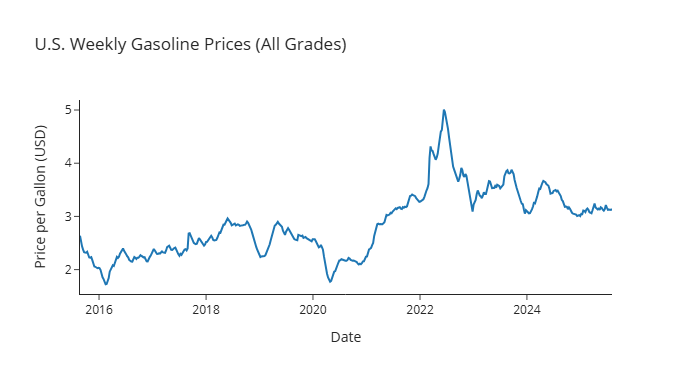

In [9]:
fig = px.line(
    df_gas,
    x="date",
    y="gas_price",
    title="U.S. Weekly Gasoline Prices (All Grades)",
    labels={"date": "Date", "gas_price": "Price per Gallon (USD)"},
    template="simple_white"
)

fig.show()

## ✅ 5. Conclusion

In this exercise, we successfully accessed multiple public economic and financial datasets using APIs, and visualized insights with `plotly`. These techniques are widely applicable for analysts working with live economic data, enabling them to automate reporting and decision-making workflows.